# Cell body - neurite interactions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

from neurorosettes import physics
from neurorosettes.subcellular import ObjectFactory

## Defining objects and interactions

In [2]:
# Define the mechanical parameters of the objects
factory = ObjectFactory(
    cell_radius=8.0,
    cell_interaction_factor=1.25,
    neurite_radius=1.0,
    neurite_interaction_factor=2.0,
    neurite_spring_constant=10.0,
    neurite_default_length=15.0,
)

# Define the mechanical parameters of the interactions
contact_function = physics.PotentialsContact(
    adhesion_coefficient=0.4, repulsion_coefficient=40.0, smoothness_factor=1
)

## Compute interaction forces

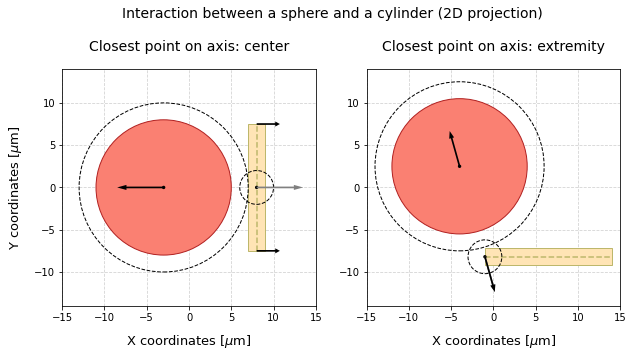

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Define the data to be plotted on each subplot
axes_names = ["center", "extremity"]
data = [
    {
        "sphere_coordinates": np.array([-3.0, 0.0, 0.0]),
        "spring_coordinates": np.array([8.0, -7.5, 0.0]),
        "growth": np.array([0.0, 1.0, 0]),
        "angle": 0,
    },
    {
        "sphere_coordinates": np.array([-4.0, 2.5, 0.0]),
        "spring_coordinates": np.array([-1.0, -8.2, 0.0]),
        "growth": np.array([1.0, 0.0, 0]),
        "angle": -90,
    },
]

for i, ax in enumerate(axes):
    # Create objects
    sphere = factory.get_cell_body(center_position=data[i]["sphere_coordinates"])
    spring = factory.get_neurite(
        proximal_position=data[i]["spring_coordinates"], axis=data[i]["growth"]
    )

    # Get the point on the cylinder axis closest to the sphere
    point = physics.get_sphere_cylinder_intersection(
        sphere.position, spring.proximal_point, spring.distal_point
    )

    # Compute interaction forces
    force, fraction = spring.get_cell_neighbor_force(sphere, contact_function)

    # Draw sphere
    ax.add_patch(
        patches.Circle(
            (sphere.position[0], sphere.position[1]),
            radius=sphere.mechanics.radius,
            edgecolor="firebrick",
            facecolor="salmon",
        )
    )

    # Draw cylinder
    rect2 = patches.Rectangle(
        (spring.proximal_point[0] - spring.mechanics.radius, spring.proximal_point[1]),
        width=spring.mechanics.radius * 2,
        height=spring.current_length,
        edgecolor="darkkhaki",
        facecolor="moccasin",
    )

    # Apply transform to cylinder (original is vertical, needs to be rotated)
    t2 = (
        transforms.Affine2D().rotate_deg_around(
            spring.proximal_point[0], spring.proximal_point[1], data[i]["angle"]
        )
        + ax.transData
    )
    rect2.set_transform(t2)
    ax.add_patch(rect2)

    # Draw the cylinder axis
    ax.plot(
        [spring.proximal_point[0], spring.distal_point[0]],
        [spring.proximal_point[1], spring.distal_point[1]],
        color="darkkhaki",
        linestyle="--",
        zorder=1,
    )

    # Draw the interaction radii
    ax.add_patch(
        patches.Circle(
            (sphere.position[0], sphere.position[1]),
            radius=sphere.mechanics.interaction_radius,
            fill=None,
            alpha=1,
            edgecolor="black",
            linestyle="--",
        )
    )

    ax.add_patch(
        patches.Circle(
            (point[0], point[1]),
            radius=spring.mechanics.interaction_radius,
            fill=None,
            alpha=1,
            edgecolor="black",
            linestyle="--",
        )
    )

    # Draw the sphere centre
    ax.add_patch(
        patches.Circle(
            (sphere.position[0], sphere.position[1]),
            radius=0.2,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    # Draw the closest point on the cylinder axis
    ax.add_patch(
        patches.Circle(
            (point[0], point[1]), radius=0.2, fill=True, alpha=1, facecolor="black"
        )
    )

    # Draw the force acting on the closest point
    ax.add_patch(
        patches.Arrow(
            x=point[0],
            y=point[1],
            dx=force[0] * 20,
            dy=force[1] * 20,
            fill=True,
            alpha=1,
            facecolor="grey",
        )
    )

    # Draw the force component transmited to the proximal point
    ax.add_patch(
        patches.Arrow(
            x=spring.proximal_point[0],
            y=spring.proximal_point[1],
            dx=force[0] * (1 - fraction) * 20,
            dy=force[1] * (1 - fraction) * 20,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    # Draw the force component transmited to the distal point
    ax.add_patch(
        patches.Arrow(
            x=spring.distal_point[0],
            y=spring.distal_point[1],
            dx=force[0] * fraction * 20,
            dy=force[1] * fraction * 20,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    # Draw the force cting on the sphere
    ax.add_patch(
        patches.Arrow(
            x=sphere.position[0],
            y=sphere.position[1],
            dx=-force[0] * 20,
            dy=-force[1] * 20,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    ax.set_xlim(-15, 15)
    ax.set_ylim(-14, 14)
    ax.set_axisbelow(True)
    ax.set_title(f"Closest point on axis: {axes_names[i]}", y=1.05, fontsize=14)
    ax.grid("both", color="lightgrey", linestyle="--")
    ax.set_aspect("equal", adjustable="box")
    if i == 0:
        ax.set_ylabel("Y coordinates [$\mu$m]", fontsize=13, labelpad=10)
    ax.set_xlabel("X coordinates [$\mu$m]", fontsize=13, labelpad=10)

fig.suptitle(
    "Interaction between a sphere and a cylinder (2D projection)", fontsize=14, y=0.92
)
plt.savefig("../../docs/img/sphere_spring.svg")
plt.show()